# Timing duration and the transient effects of artificial propogation 

Most of the theoretical work on describing the effect of artificial propogation on the fittness of natrual populaitons has focused on the long run or steady state outcomes of these programs. this is a very reasonable aproach for many application where propogatin is expected to be continued indefinitly (e.g. aquaculture, sumplimentation for harvest). However, when artificial propogation is used for conservation purposes it is often viewed as an emergency stop gap measure designed to have a limited duration, thus it is critical to understand the short run or transtent effects of these programs. Furthermore, tunderstanding the tranistent response of a system to an intervention like hatcheyr production can be important for measuring the response of the popuatlion to the intervention. 
 

In this module I will use simulation to test the effect of releasing maladapted individuals into a population. I will show the long run effects of these action if the program was maintained indefinitly and compare them to a case where stocking occurs for a limited period of time. I will also consider three other important factors: the degree of maladaption among the propogated individuals, the strength of selection and the productivity of the natrual population.

The model I will simulate from is an age structured model that describes the genetic differnces between natrual and propogated individuals with the Slatkin (1970) model of a quantitative genetic character. The age sturctured popualtion dynamics will be parameterized to represent white sturgeon popualtion in the Fraser River British Columbia using data from previous stock assessment. 

## Initialize the model

The model uses demogrphic paramters from a previous analysis of these stocks by Smyth et. al. (2016). The life table paramters from their analysis are used to represent the age structured dynamics of the population. The relationship between the abundace of adults and recruitment is unknown, we assume it follow a saturating, Beverton-Holt curve with compensation parameter  $k = 3$ in our base paramterization. 

No prior analyses are avaialbe to form a basis for the genetic paramters, so we test a range of values in this analysis. The optimal trait value for the natural population $\theta$ is set to $0.0$ $w.l.o.g$ and like wise the variance at linkage equilibrium $V_{Le} = 1$. For these simmulation we model the effect of introducing maladapted individuals to the populaiton. The effects of these individuals will depend on their rate of introduction $R_{im}$ and the degree of maladaptaion $\Delta z$. 

Finally, inaddition to these parameter values, the order of life cycle events will effect the population dynamics. The four key life cycle events are reproduction, density dependent mortality, immigration and selection. Reproduciton is always first, this leave $3! = 6$ arrangements of the other three events. In the base model we assume the ordering is  reproduction, density dependent mortality, selection and immigration. 

In [ ]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using Plots
theme(:wong2)

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod)
k = 3.0


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.15

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

## Example simulaiton

To demostrate the temporal dynamics of the system in the following block we run simulation of the popualtion dynamics for 1000 years with a 100 year period of stocking from year 100 to year 200. This is roughly 2 generations for the sturgeon populations. the plots show the changes in the fittness, abundance, and the trait distribution over time. It is noteable that the introduction of migrants to the popualtion causes a significant linkage disequilibrium as can be seen the increase in variance of the trait distribution. 

In [ ]:
theme(:wong2)
s = 0.1
AgeTraitStructuredModels.reset!(pop,s)

T = 1000
t_stock = 100
T_stock = 200
fittness = zeros(T)
recruitment = zeros(T)
SSB = zeros(T)
mu, sigma = zeros(T), zeros(T)
for t in 1:T
    if t < t_stock
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    elseif t < T_stock
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop) - im.N
    else
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    end 
    fittness[t] = AgeTraitStructuredModels.fittness(pop)
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
    mu[t], sigma[t] = AgeTraitStructuredModels.trait_moments_born(pop)
end 
p1 = Plots.plot(fittness, ylab = "Fittness", label = "")
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
p3 = Plots.plot(mu, ylab = "mean", xlab = "Years")
p4 = Plots.plot(sigma.^2, ylab = "variance", xlab = "Years")
plot(p1,p2,p3,p4, layout = (2,2))

## Long run outcomes 

To develop an understanding for how key model parameters and structural assumptions effect outcomes we can analyze the long run equilibrium state of the popuatlion as a function of these unknown quantities. The block below provides methods to solve for stable equilbriums in the model. 


In [ ]:

function equilibrium(population, update!, immigrants, s, prop_im, μ_im, before)
    AgeTraitStructuredModels.reset!(population,0.2)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    Estar = AgeStructuredModels.compute_Rstar(population.ageStructure) * AgeStructuredModels.LEP(population.ageStructure)
    if before  
        AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Estar, μ_im)
    else
        AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Rstar, μ_im)
    end
    W0 = 10
    W1 = AgeTraitStructuredModels.spawning_stock(population)
    iter = 0
    while abs(W0 - W1) > 10^-5.0
        iter += 1
        W0 = W1
        update!(pop,im)
        W1 = AgeTraitStructuredModels.spawning_stock(population)
    end 

    μrec, σrec = AgeTraitStructuredModels.trait_moments_recruits(population)
    μSSB, σSSB = AgeTraitStructuredModels.trait_moments_spawning(population)
    W = AgeTraitStructuredModels.fittness(population)
    SSB = AgeTraitStructuredModels.spawning_stock(population)
    rec = AgeTraitStructuredModels.recruitment(population)
    
    return W, SSB, rec, μrec, σrec, μSSB, σSSB
end  

# before if immigration before density dependence 
function min_outcomes(population,  update!, immigrants, T, s, prop_im, μ_im, before)
    AgeTraitStructuredModels.reset!(population,0.2)
    Rstar = AgeStructuredModels.compute_Rstar(population.ageStructure)
    Estar = AgeStructuredModels.compute_Rstar(population.ageStructure) * AgeStructuredModels.LEP(population.ageStructure)
    if before  
        AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Estar, μ_im)
    else
        AgeTraitStructuredModels.reset_immigrants!(immigrants,population, prop_im*Rstar, μ_im)
    end 
    W0 = 10
    F0 = 10
    W1 = AgeTraitStructuredModels.spawning_stock(population)
    F1 = AgeTraitStructuredModels.fittness(population)
    iter = 0
    Fmin = -1
    flip = true
    while (W0 > W1) | flip
        iter += 1
        W0 = W1
        F0 = F1
        if iter < T
             update!(pop,im)
        else
             update!(pop)
        end
        W1 = AgeTraitStructuredModels.spawning_stock(population)
        F1 = AgeTraitStructuredModels.fittness(population)
        if (F0 < F1) & (Fmin == -1)
            Fmin = F1
        end 
        
        if flip & (W0 > W1)
            flip = false
        end 
        
    end 
   
    return Fmin, W1
end 

## Effect of immigration rate

The two primary factors that determine the effect of hathchery stocking are the degree of maladaptaiton and the rate number of individuals that are intorduced. The figures below show the equilibrium fittness and population size as a function of the degree of maladaptaion $\Delta z$ for differnt rates of immigraitons (as a proportion of the equilibrium recruitment rate in the absence of stocking). 

In [ ]:

μim = 0.0:1.0:10
s, prop_im = 0.1, 0.1
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> equilibrium(pop,AgeTraitStructuredModels.time_step_DSI!, im, s, prop_im, x, false)[1:2], μim )
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )

for prop_im in 0.12:0.04:0.25
    W = broadcast(x -> equilibrium(pop,AgeTraitStructuredModels.time_step_DSI!, im, s, prop_im, x,  false)[1:2], μim)
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im))
end


plot(p1,p2, layout = (2,1))

## The order of life cycle events

The order of life cycle events will also determine long run effects of stocking. As previously discused there are three key life cycle events that occur after birth, density dependence, selection and immigration. There are six possible orders of these events each of which result in unique dynamics. These differnces in the dynamics also yield differnt responses to the the introduction of maladapted individuals. In particular, when selection occurs after immigraiton the effect are mitigated because maladapted individuals are removed before they can reproduce and when selection occurs before density dependence, the demographic effect of selection are softened. In this case selection produces differnces in fittenss between individuals but has a limited effect on fittness at the popualtion level, because trait dependent mortaility displaces density dependnet mortaility. 

The effects of the alternative orderings are shown below for differnt values of $\Delta z$, $s=1$and $p_{im} = 0.2$ 

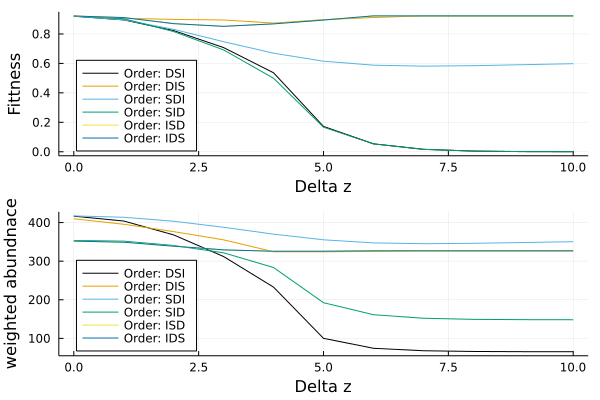

In [5]:

μim = 0.0:1.0:10
s, prop_im = 0.1, 0.2
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> equilibrium(pop, AgeTraitStructuredModels.time_step_DSI!, im, s, prop_im, x, false)[1:2], μim )
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = "Order: DSI",
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = "Order: DSI",
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )

W = broadcast(x -> equilibrium(pop, AgeTraitStructuredModels.time_step_DIS!, im, s, prop_im, x, false)[1:2], μim)
Plots.plot!(p1, μim, broadcast(i -> W[i][1], 1:length(μim )),label = "Order: DIS",
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
Plots.plot!(p2, μim, broadcast(i -> W[i][2], 1:length(μim )),label = "Order: DIS",
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )

W = broadcast(x -> equilibrium(pop, AgeTraitStructuredModels.time_step_SDI!, im, s, prop_im, x, false)[1:2], μim )
Plots.plot!(p1, μim, broadcast(i -> W[i][1], 1:length(μim )),label = "Order: SDI",
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
Plots.plot!(p2, μim, broadcast(i -> W[i][2], 1:length(μim )),label = "Order: SDI",
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )
R_im = prop_im 
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
W = broadcast(x -> equilibrium(pop, AgeTraitStructuredModels.time_step_SID!, im, s, prop_im, x, true )[1:2], μim)
Plots.plot!(p1, μim, broadcast(i -> W[i][1], 1:length(μim )),label = "Order: SID",
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
Plots.plot!(p2, μim, broadcast(i -> W[i][2], 1:length(μim )),label = "Order: SID",
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )

W = broadcast(x -> equilibrium(pop, AgeTraitStructuredModels.time_step_ISD!, im, s, prop_im, x, true )[1:2], μim)
Plots.plot!(p1, μim, broadcast(i -> W[i][1], 1:length(μim )),label = "Order: ISD",
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
Plots.plot!(p2, μim, broadcast(i -> W[i][2], 1:length(μim )),label = "Order: ISD",
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )

W = broadcast(x -> equilibrium(pop, AgeTraitStructuredModels.time_step_ISD!, im, s, prop_im, x, true)[1:2], μim )
Plots.plot!(p1, μim, broadcast(i -> W[i][1], 1:length(μim )),label = "Order: IDS",
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
Plots.plot!(p2, μim, broadcast(i -> W[i][2], 1:length(μim )),label = "Order: IDS",
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )

plot(p1,p2, layout = (2,1))

The largest fittness effects occur when selection occurs before immigration. These translate into the largest demographic effects when selection occurs after density dependence. Given the rate of immigraiton and strength of seleciton tested here,  there are very few fittness effects if immigration occurs before seleciton. 

## Interactions between order of events and other parameters

the order of events changes the long run effects of stocking, but it also mediates the effects of other paramters such as selection strength and the rate of immigration. To illustrate this the next two block produce the same plot showing the effect of the immigration rate $p_{im}$ on the relationship between $\Delta z$ and fittness, abundance for two orderings of life cycle events. 

Note that other paramters have been changed as well sepcifically, the selection strength $s = 0.05$ and the range of $p_{im} \in [0.1,0.7]$

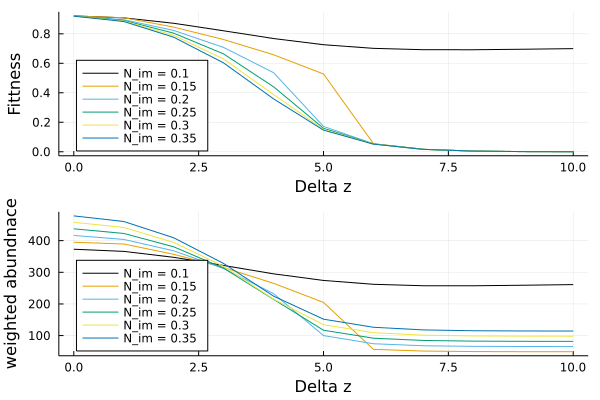

In [6]:
μim = 0.0:1.0:10
s, prop_im = 0.05, 0.1
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> equilibrium(pop,AgeTraitStructuredModels.time_step_DSI!, im, s, prop_im, x, false)[1:2], μim )
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "Delta z", ylab = "Fittness" )
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomleft, xlab = "Delta z", ylab = "weighted abundnace" )

for prop_im in 0.15:0.05:0.35
    W = broadcast(x -> equilibrium(pop,AgeTraitStructuredModels.time_step_DSI!, im, s, prop_im, x,  false)[1:2], μim)
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im))
end


plot(p1,p2, layout = (2,1))

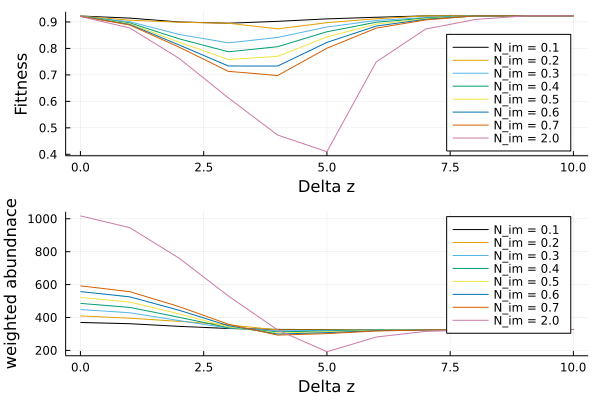

In [7]:
μim = 0.0:1.0:10
s, prop_im = 0.05, 0.1
#equilibrium(pop, im, s, prop_im, 5)
W = broadcast(x -> equilibrium(pop,AgeTraitStructuredModels.time_step_DIS!, im, s, prop_im, x, false)[1:2], μim )
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:bottomright, xlab = "Delta z", ylab = "Fittness" )
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im),
                legend =:topright, xlab = "Delta z", ylab = "weighted abundnace" )

for prop_im in vcat(collect(0.2:0.1:0.7), [2.0])
    W = broadcast(x -> equilibrium(pop,AgeTraitStructuredModels.time_step_DIS!, im, s, prop_im, x,  false)[1:2], μim)
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("N_im = ", prop_im) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("N_im = ", prop_im))
end


plot(p1,p2, layout = (2,1))

In both cases we see that the fittness effects of stocking increase with the number of introduced individuals. However, they are limited when selection occus after immigration.  

# The effects of temporary programs

Although the long run effect of a stocking program provide a useful starting point, our goal is to understand the likely effect of a temporary stocking program used as a stop gap measure to prevent local extinctions. We can characterize the effects of these programs by looking at the minimum abundance and fitness of the natrual population after stocking begins. These minimum values may not be the only important quantity, but the do provide a useful starting point. 

the following section showes the effect of key model paramters on the short run outcomes of a stocking programs starting with the duration of the program.

## Program duration

The block below plots the minimum fittnes and abundace of a popualtion after stocking begins. The program duration is expressed in generation times.  

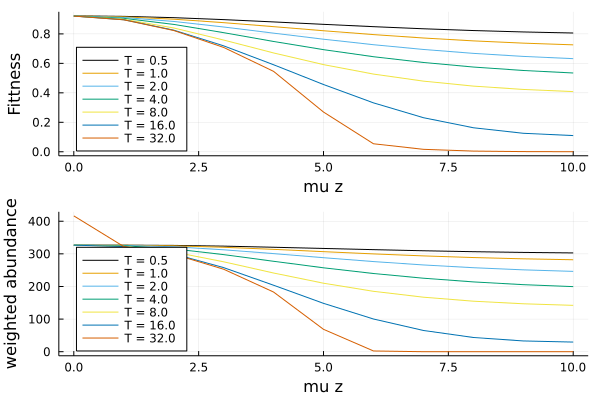

In [8]:
include("DemographicParameters.jl")
μim = 0.0:1.0:10
s, prop_im = 0.1, 0.2
Tgen =  DemographicParameters.Smyth_2016_T1
T = 0.5*Tgen
theme(:wong2)
#equilibrium(pop, im, s, prop_im, 5)
Tg = round(T / DemographicParameters.Smyth_2016_T1, digits = 1)
W = broadcast(x -> min_outcomes(pop,AgeTraitStructuredModels.time_step_DSI!, im, T, s, prop_im, x, false)[1:2], μim )
p1 = Plots.plot(μim, W)
p1 = Plots.plot(μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = ", Tg),
                legend =:bottomleft, xlab = "mu z", ylab = "Fittness")
p2 = Plots.plot(μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("T = ", Tg),
                legend =:bottomleft, xlab = "mu z", ylab = "weighted abundance" )
for T in Tgen.*[1,2,4,8,16,32]
    W = broadcast(x -> min_outcomes(pop,AgeTraitStructuredModels.time_step_DSI!, im, T, s, prop_im, x, false)[1:2], μim )
    Tg = round( T / DemographicParameters.Smyth_2016_T1, digits = 1)
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = ", Tg) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("T = ", Tg) )
end 


plot(p1,p2, layout = (2,1))

## Effects of timing for differnt order of events 

In [28]:
μim = 0.0:1.0:10
s, prop_im = 0.05, 2.0
Tgen =  DemographicParameters.Smyth_2016_T1
T = 0.5*Tgen
theme(:wong2)
#equilibrium(pop, im, s, prop_im, 5)
Wls = []

for T in Tgen.*[0.5, 1,2,4,8,16,32]
    W = broadcast(x -> min_outcomes(pop,AgeTraitStructuredModels.time_step_DIS!, im, T, s, prop_im, x, false)[1:2], μim )
    Tg = round( T / DemographicParameters.Smyth_2016_T1, digits = 1)
    push!(Wls,W)
#     Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = ", Tg) )
#     Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("T = ", Tg) )
end 


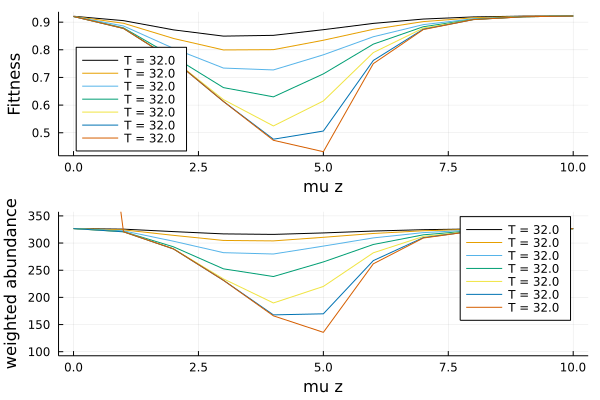

In [32]:

p1 = Plots.plot(μim, broadcast(i -> Wls[1][i][1], 1:length(μim )),label = string("T = ", Tg),
                legend =:bottomleft, xlab = "mu z", ylab = "Fittness")
p2 = Plots.plot(μim, broadcast(i -> Wls[1][i][2], 1:length(μim )),label = string("T = ", Tg),
                legend =:topright, xlab = "mu z", ylab = "weighted abundance" )
for W in Wls[2:end]
    Plots.plot!(p1,μim, broadcast(i -> W[i][1], 1:length(μim )),label = string("T = ", Tg) )
    Plots.plot!(p2,μim, broadcast(i -> W[i][2], 1:length(μim )),label = string("T = ", Tg), ylims = [100,350] )
end 


plot(p1,p2, layout = (2,1))

These preliminary results show that the fittness effect of a stocking programs are heavily determined by its duration. In the previous figures, the paramter values were set such that stocking could cause a large enough decline in fittness for the natrual popualtion to effectivley become extinct. However, there are only very fittness effects when stocking occurs for two generations or less. this demonstrates that the genetic effects of hatchery programs take time to accumulate. There are two possible mechanisms that might cause this delay. The first is that the introduction of maladapted individuals causes significant linkage disequilibrium. Likeage disequilibrium increases the variance of the trait in the popualtion and thus the efficency of seleciton. However, is stocking is persistent, linkage disequilibrium declines over time reducing the efficency of seleciton which in turn increases the potential fitness effects from stocking. 

Furthermore, in some cases there maybe feedback loops  between the abundace of natrual born individuals popualtion and the proportion of the total popualtion produced by the hatchery that cause a tipping point. Where the popualtion goes from bing dominated by natrual reproduction to being dominated by artificail propogation. The change in popuatlion size near this tipping point is likely to be slow as the popuation traversess a saddle point in phase space. 


The block of cobe below shows the trainsient increase in the trait variance which slows the popualtions apraoch to it's new equilibrium. 

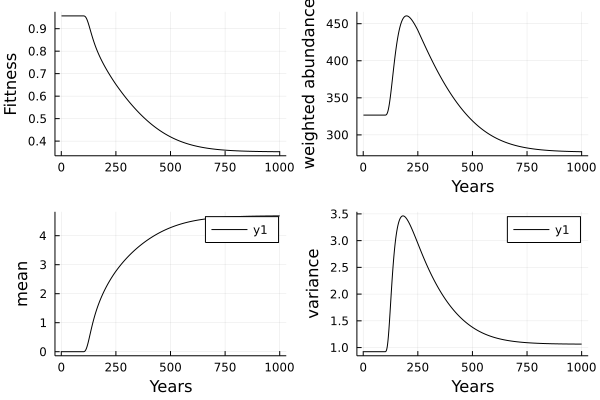

In [10]:
## reset paramters 
k = 3.0


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.15

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")

s = 0.1
AgeTraitStructuredModels.reset!(pop,s)

T = 1000
t_stock = 100
T_stock = 1000
fittness = zeros(T)
recruitment = zeros(T)
SSB = zeros(T)
mu, sigma = zeros(T), zeros(T)
for t in 1:T
    if t < t_stock
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    elseif t < T_stock
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop) - im.N
    else
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    end 
    fittness[t] = AgeTraitStructuredModels.fittness(pop)
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
    mu[t], sigma[t] = AgeTraitStructuredModels.trait_moments_born(pop)
end 
p1 = Plots.plot(fittness, ylab = "Fittness", label = "")
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
p3 = Plots.plot(mu, ylab = "mean", xlab = "Years")
p4 = Plots.plot(sigma.^2, ylab = "variance", xlab = "Years")
plot(p1,p2,p3,p4, layout = (2,2))

# Simplified models to illustrate effects of LD and saddel point on transient dynamics. 

To illustrate the effects of the linkage disequilibrium induced by geneflow on the transient dynamcis of the model we can compare simulation of the model that track the full trait distribution to simulations that assume the trait distribution has a fixed varinace. This is not a perfect test becasue the long run dynamics of these two models can also differ, but it should provide some intution. 

The block of code below simulates 300 generations of a popuatlion with immigration starting in generation 10. Individuals in the popuatlion are semelparious and generations do not overlap. The trait distribution is plotted in each generation. The paramters are set such that the popuaton will cross a thrshold and the popualtion will loose its local adaptation and become a sink supplied only by imnigrants. The variance of the trait distribution is large while the popualtion transits to this new equilibrium.  

In [1]:
include("TraitStructuredPopulation.jl")
r = 3
k = 1
Nstar = k*(r-1)/r
sr = x -> r*x/(1 +r*x/k)

Vle = 1
theta = 0
s = 0.1
Δz = 5
pop = TraitStructuredPopulation.init(sr, Nstar, Vle, theta, s, -5, 15, 0.1)
p_im = 0.2
im = TraitStructuredPopulation.init_imigrants(pop, p_im*Nstar, Δz)
print(" ")

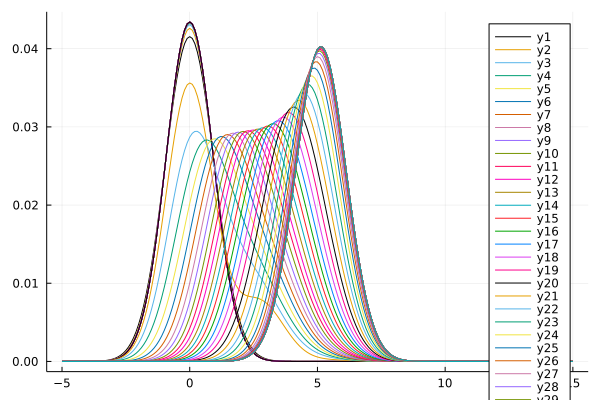

In [15]:
include("TraitStructuredPopulation.jl")
r = 2.0
k = 1
Nstar = k*(r-1)/r
sr = x -> r*x/(1 +r*x/k)
theme(:wong2)
Vle = 1
theta = 0
s = 0.1
Δz = 6.0
pop = TraitStructuredPopulation.init(sr, Nstar, Vle, theta, s, -5, 15, 0.1)
p_im = 0.15
im = TraitStructuredPopulation.init_imigrants(pop, p_im*Nstar, Δz)
print(" ")

using Plots
T = 70
Tstart = 20
p1 = Plots.plot(pop.grid, pop.trait)
μt = zeros(T)
σt = zeros(T)
Nt = zeros(T)
Wt = zeros(T)
for t in 1:T
    if t < Tstart
        TraitStructuredPopulation.time_step_DSI(pop)
        Plots.plot!(p1,pop.grid, pop.trait)
        μt[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness(pop)
    else
        TraitStructuredPopulation.time_step_DSI(pop,im)
        Plots.plot!(p1,pop.grid, pop.trait)
        μt[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness(pop)
    end
end 
p = p1
p1 = Plots.plot(μt, label = "Linkage")
p2 = Plots.plot(σt, label = "Linkage")
p3 = Plots.plot(Nt, label = "Linkage")
p4 = Plots.plot(Wt, label = "Linkage")

# reset model and simulate without linkage disequilibirum 
TraitStructuredPopulation.reset!(pop,Nstar)
# constant variance
V_star = 0.985
pop.V = V_star

μt1 = zeros(T)
σt = zeros(T)
Nt = zeros(T)
Wt = zeros(T)
for t in 1:T
    if t < Tstart
        TraitStructuredPopulation.time_step_DSI_N(pop)
        μt1[t] = pop.mu
        σt[t] = pop.V
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness_N(pop)
    else
        TraitStructuredPopulation.time_step_DSI_N(pop,im)
        #μt1[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        μt1[t] = pop.mu
        σt[t] = pop.V
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness_N(pop)
    end
end 


Plots.plot!(p1, μt1, label = "No Linkage", title = "mean", legend =:bottomright,
    xlabel = "time", ylabel = "Mean tait")
Plots.plot!(p2,σt, label = "No Linkage", title = "varinace",
    xlabel = "time", ylabel = "Trait variance")
Plots.plot!(p3,Nt, label = "No Linkage", title = "abundance",
    xlabel = "time", ylabel = "Abundance", legend =:topright)
Plots.plot!(p4, Wt,  label = "No Linkage", title = "fitness",
    xlabel = "time", ylabel = "fitness", legend =:topright)
p

## Linakge diequilibrium changes the transient dynmaics (increase time to new equilbirum) 

The following code runs the model with a fixed trait variance. The initial and final popualtion sizes and trait distributions are very similar, but the transition is much slower when the model accounts for LD.  

In [16]:
theme(:wong2)
plot(p1,p2,p3,p4 )
png("figures/linkage_DE.png")

## The feedback between popualtion size and percapita immigraiton rate creates a "ghost" attractor

the gost is caused by a portion of phase space near a saddel node bifrucation point.


In [19]:
include("TraitStructuredPopulation.jl")
r = 2.0
k = 1
Nstar = k*(r-1)/r
sr = x -> r*x/(1 +r*x/k)

Vle = 1
theta = 0
s = 0.1
Δz = 6.0
pop = TraitStructuredPopulation.init(sr, Nstar, Vle, theta, s, -5, 15, 0.1)
p_im = 0.07
im = TraitStructuredPopulation.init_imigrants(pop, p_im*Nstar, Δz)
print(" ")

using Plots
T = 200
Tstart = 20
p1 = Plots.plot(pop.grid, pop.trait)
μt = zeros(T)
σt = zeros(T)
Nt = zeros(T)
Wt = zeros(T)
for t in 1:T
    if t < Tstart
        TraitStructuredPopulation.time_step_DSI(pop)
        Plots.plot!(p1,pop.grid, pop.trait)
        μt[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness(pop)
    else
        TraitStructuredPopulation.time_step_DSI(pop,im)
        Plots.plot!(p1,pop.grid, pop.trait)
        μt[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness(pop)
    end
end 
p = p1
p1 = Plots.plot(μt, label = "", legend =:bottomright,
xlabel = "time", ylabel = "Mean tait")
p2 = Plots.plot(σt, label = "", legend =:none,xlabel = "time", ylabel = "Trait variance")
p3 = Plots.plot(Nt, label = "",xlabel = "time", ylabel = "Abundance")
p4 = Plots.plot(Wt, label = "",xlabel = "time", ylabel = "fitness")

plot(p1,p2,p3,p4)
png("figures/Ghost.png")

## These two processes reduce the impact of temporary stocking programs

In [17]:
# update paramters 
r = 2.0
k = 1
Nstar = k*(r-1)/r
sr = x -> r*x/(1 +r*x/k)

Vle = 1
theta = 0
s = 0.1
Δz = 6.0
pop = TraitStructuredPopulation.init(sr, Nstar, Vle, theta, s, -5, 15, 0.1)
p_im = 0.15
im = TraitStructuredPopulation.init_imigrants(pop, p_im*Nstar, Δz)

pop.V = 0.92

T = 80
Tstart = 10
Tend = 20
p1 = Plots.plot(pop.grid, pop.trait)
μt1 = zeros(T)
σt = zeros(T)
Nt = zeros(T)
Wt = zeros(T)

for t in 1:T
    if t < Tstart
        TraitStructuredPopulation.time_step_DSI(pop)
        Plots.plot!(p1,pop.grid, pop.trait)
        μt1[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness(pop)
    elseif t < Tend
        TraitStructuredPopulation.time_step_DSI(pop,im)
        Plots.plot!(p1,pop.grid, pop.trait)
        μt1[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness(pop)
    else 
        TraitStructuredPopulation.time_step_DSI(pop)
        Plots.plot!(p1,pop.grid, pop.trait)
        μt1[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness(pop)
    end
end 

p1 = Plots.plot(μt1, label = "Linkage")
p2 = Plots.plot(σt, label = "Linkage")
p3 = Plots.plot(Nt, label = "Linkage")
p4 = Plots.plot(Wt, label = "Linkage")
print(" ")



TraitStructuredPopulation.reset!(pop,Nstar)


μt = zeros(T)
σt = zeros(T)
Nt = zeros(T)
Wt = zeros(T)
for t in 1:T
    if t < Tstart
        TraitStructuredPopulation.time_step_DSI_N(pop)
        μt[t] = pop.mu
        σt[t] = pop.V
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness_N(pop)
    elseif t < Tend
        TraitStructuredPopulation.time_step_DSI_N(pop,im)
        μt[t],σt[t] = TraitStructuredPopulation.trait_moments(pop)
        μt[t] = pop.mu
        σt[t] = pop.V
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness_N(pop)
    else
        TraitStructuredPopulation.time_step_DSI_N(pop)
        μt[t] = pop.mu
        σt[t] = pop.V
        Nt[t] = pop.N
        Wt[t] = TraitStructuredPopulation.fitness_N(pop)
    end
end 

theme(:wong2)
Plots.plot!(p1, μt, label = "No linkage",xlabel = "time", ylabel = "Mean")
Plots.plot!(p2,σt, label = "No linkage",xlabel = "time", ylabel = "Variance")
Plots.plot!(p3,Nt, label = "No linkage",xlabel = "time", ylabel = "Abundace", legend =:bottomright)
Plots.plot!(p4, Wt, label = "No linkage",xlabel = "time", ylabel = "Fitness", legend =:bottomright)

plot(p1,p2,p3,p4)
png("figures/linkage_temp_DE.png")

# Effect of demographic stochasticity

In [65]:
include("AgeStructuredModels.jl")
include("DemographicParameters.jl")
include("AgeTraitStructuredModels.jl")
include("StockRecruitCurves.jl")
using Plots
theme(:wong2)

# initialize demographic model - paramters loaded from DemographicParameters.jl 
# see tests in "TestDemographicParametersparams.ipynb"
mod = AgeStructuredModels.init(150,DemographicParameters.Smyth_2016_sr,DemographicParameters.Smyth_2016_survival,
    DemographicParameters.Smyth_16_F_vec)

Rstar = AgeStructuredModels.compute_Rstar(mod)
k = 1.5


# set base genetic paramters
Vle = 1.0
θ = 0.0
s = 0.1
min = -5
max = 20 
Δz = 0.15

# set base paramters for propogated individuals 
μ_im = 5.0
R_im = 0.5 * Rstar  # 50% natrual recrutment 

# initialize coupled genetic-demogrpahic model 
pop = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
StockRecruitCurves.update_BevetonHolt_k!(pop.ageStructure.SRCurve, k)
im = AgeTraitStructuredModels.init_imigrants(pop, R_im, μ_im)
print(" ")



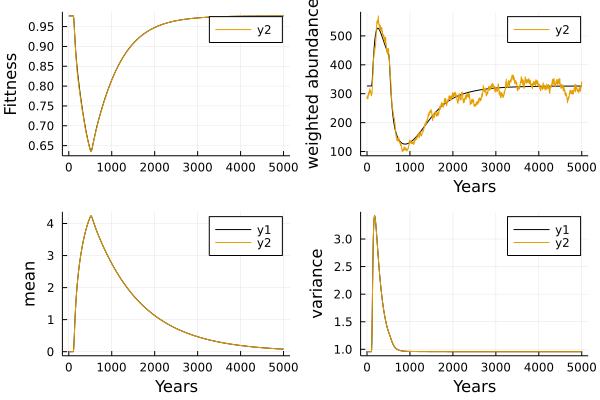

In [82]:
theme(:wong2)
s = 0.05
AgeTraitStructuredModels.reset!(pop,s)

T = 5000
t_stock = 100
T_stock = 500
fittness = zeros(T)
recruitment = zeros(T)
SSB = zeros(T)
mu, sigma = zeros(T), zeros(T)


pop_S = AgeTraitStructuredModels.init(mod,Vle, θ, s, min, max, Δz)
AgeTraitStructuredModels.reset!(pop_S,s)

fittness_S = zeros(T)
recruitment_S = zeros(T)
SSB_S = zeros(T)
mu_S, sigma_S = zeros(T), zeros(T)

for t in 1:T
    if t < t_stock
        AgeTraitStructuredModels.time_step_DSI_S!(pop_S,0, 0.1)
        recruitment_S[t] = AgeTraitStructuredModels.recruitment(pop_S)
        
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    elseif t < T_stock
        AgeTraitStructuredModels.time_step_DSI_S!(pop_S,im,0, 0.1)
        recruitment_S[t] = AgeTraitStructuredModels.recruitment(pop_S) - im.N
        
        AgeTraitStructuredModels.time_step_DSI!(pop,im)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop) - im.N
    else
        AgeTraitStructuredModels.time_step_DSI_S!(pop_S,0, 0.1)
        recruitment_S[t] = AgeTraitStructuredModels.recruitment(pop_S)
        
        AgeTraitStructuredModels.time_step_DSI!(pop)
        recruitment[t] = AgeTraitStructuredModels.recruitment(pop)
    end 
    fittness_S[t] = AgeTraitStructuredModels.fittness(pop_S)
    SSB_S[t] = AgeTraitStructuredModels.spawning_stock(pop_S)
    mu_S[t], sigma_S[t] = AgeTraitStructuredModels.trait_moments_born(pop_S)
    
    fittness[t] = AgeTraitStructuredModels.fittness(pop)
    SSB[t] = AgeTraitStructuredModels.spawning_stock(pop)
    mu[t], sigma[t] = AgeTraitStructuredModels.trait_moments_born(pop)
end 
p1 = Plots.plot(fittness, ylab = "Fittness", label = "")
Plots.plot!(p1, fittness_S)
p2 = Plots.plot(SSB, ylab = "weighted abundance", xlab = "Years", label = "")
Plots.plot!(p2, SSB_S)
p3 = Plots.plot(mu, ylab = "mean", xlab = "Years")
Plots.plot!(p3, mu)
p4 = Plots.plot(sigma.^2, ylab = "variance", xlab = "Years")
Plots.plot!(p4, sigma.^2)
plot(p1,p2,p3,p4, layout = (2,2))

In [ ]:
# Removals: